<a href="https://colab.research.google.com/github/akshaygrao77/DeepLearning-Assignment3/blob/main/DL_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras.utils.vis_utils import plot_model

In [12]:
!curl https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar --output daksh.tar
!tar -xvf  'daksh.tar' 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1915M  100 1915M    0     0   192M      0  0:00:09  0:00:09 --:--:--  158M
dakshina_dataset_v1.0/bn/
dakshina_dataset_v1.0/bn/lexicons/
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv
dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv
dakshina_dataset_v1.0/bn/native_script_wikipedia/
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.valid.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-full.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.info.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.sorted.tsv.gz
dakshina_dataset_v1.0/bn/native_script_wikipedia/bn.wiki-filt.train.text.shuf.txt.gz
dakshina_dataset_v1.0/bn/native_script

In [13]:
def obtain_input_target_data_from_path(path,tokenizer_obj):
  input_texts = []
  target_texts = []
  
  df = pd.read_csv(path,sep="\t",names=["1", "2","3"]).astype(str)
  if tokenizer_obj is None:
    # Shuffle rows in random order with a fixed seed(for reproducability)
    df=df.sample(frac=1,random_state=1)
  # Add all the  input and target texts with start sequence and end sequence added to target 
  for index, row in df.iterrows():
      input_text=row['2']
      target_text= row['1']
      # Skip empty lines/words
      if target_text =='</s>' or input_text=='</s>':
        continue
      
      target_text = "\t" + target_text + "\n"
      input_texts.append(input_text)
      target_texts.append(target_text)
  
  return input_texts, target_texts

In [14]:
def convert_text_to_sequences(tokenizer_obj,inp_texts):
  if tokenizer_obj is None:
    tokenizer_obj = tf.keras.preprocessing.text.Tokenizer(filters='', char_level=True)
    tokenizer_obj.fit_on_texts(inp_texts)
  ret_tensor = tokenizer_obj.texts_to_sequences(inp_texts)
  ret_tensor = tf.keras.preprocessing.sequence.pad_sequences(ret_tensor,padding='post')

  return ret_tensor,tokenizer_obj

In [15]:
# This method converts a dataset(from path) to input and target sequences
def pre_process_data(path,input_tokenizer=None,target_tokenizer=None,input_length=None,target_length=None):
  
  input_texts, target_texts = obtain_input_target_data_from_path(path,input_tokenizer)
  
  input_tensor,input_tokenizer = convert_text_to_sequences(input_tokenizer,input_texts)
  
  target_tensor,target_tokenizer = convert_text_to_sequences(target_tokenizer,target_texts)
  
  # Above functions return padded version wrt longest sequence in the given list of sequence
  # The below function, pads more zeros wrt input_length and target_length
  if input_length is not None and target_length is not None:
      input_tensor=tf.concat([input_tensor,tf.zeros((input_tensor.shape[0],input_length-input_tensor.shape[1]))],axis=1)
      target_tensor=tf.concat([target_tensor,tf.zeros((target_tensor.shape[0],target_length-target_tensor.shape[1]))],axis=1)
  return input_texts,input_tensor,input_tokenizer,target_texts,target_tensor,target_tokenizer

In [16]:
transliteration_target_language = 'kn'

In [17]:
train_input_texts,train_input_tensor,input_tokenizer,train_target_texts,train_target_tensor,target_tokenizer = pre_process_data("/content/dakshina_dataset_v1.0/"+transliteration_target_language+"/lexicons/"+transliteration_target_language+".translit.sampled.train.tsv")
# Only training dataset is used to fit the tokenizer on text. Other datasets just use this vocab for pre-processing
# The length for padding is also set from training datasets
val_input_texts,val_input_tensor,val_input_tokenizer,val_target_texts,val_target_tensor,val_target_tokenizer = pre_process_data("/content/dakshina_dataset_v1.0/"+transliteration_target_language+"/lexicons/"+transliteration_target_language+".translit.sampled.dev.tsv",input_tokenizer,target_tokenizer,train_input_tensor.shape[1],train_target_tensor.shape[1])
test_input_texts,test_input_tensor,test_input_tokenizer,test_target_texts,test_target_tensor,test_target_tokenizer = pre_process_data("/content/dakshina_dataset_v1.0/"+transliteration_target_language+"/lexicons/"+transliteration_target_language+".translit.sampled.test.tsv",input_tokenizer,target_tokenizer,train_input_tensor.shape[1],train_target_tensor.shape[1])

In [64]:
print(test_input_tensor.shape)

(5047, 26)


In [66]:
print(train_input_texts[:2])
print(train_input_tensor[:2])
# print(train_target_texts[:10])
# print(train_target_tensor[:10])
print(len(train_input_texts))
print(train_input_tensor.shape)
# print(len(train_target_texts))
# print(train_target_tensor.shape)

['sketing', 'pityutari']
[[11 14  9  6  2  3 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [18  2  6 15  7  6  1  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]
50624
(50624, 26)


In [19]:
num_encoder_tokens = len(input_tokenizer.word_index)+1
num_decoder_tokens = len(target_tokenizer.word_index)+1
max_encoder_seq_length =  train_input_tensor.shape[1]
max_decoder_seq_length = train_target_tensor.shape[1]

In [20]:
print(num_encoder_tokens)
print(num_decoder_tokens)
print(max_encoder_seq_length)
print(max_decoder_seq_length)

27
64
26
26


In [21]:
print(input_tokenizer.word_index.keys())

dict_keys(['a', 'i', 'n', 'r', 'd', 't', 'u', 'h', 'e', 'l', 's', 'g', 'v', 'k', 'y', 'o', 'm', 'p', 'b', 'c', 'j', 'w', 'f', 'q', 'z', 'x'])


In [29]:
def build_layered_RNN_model(rnn_type,embedding_in_dim,embedding_out_dim,layers,dropout,inp_length,model_out_dim,initial_state = None):
   #input layer ; takes in tokenize input
  model_inputs = keras.Input(shape=( inp_length))
  #embedding layer
  embed = keras.layers.Embedding(embedding_in_dim, embedding_out_dim)(model_inputs)
  
  last_layer_model = None
  if rnn_type == 'LSTM':
    #adding everything except the last LSTM layer, because in last layer return state=True
    for i in range(layers):
      layered_model = keras.layers.LSTM(model_out_dim, return_sequences=True,return_state=True,dropout=dropout)
      if i==0:
        inp_layer = embed
      else:
        inp_layer = last_layer_model
      
      model_layer_out,state_h, state_c = layered_model(inp_layer,initial_state)
      
      last_layer_model = model_layer_out
    
    model_states = [state_h, state_c]
    
  elif rnn_type=='GRU':
    #adding everything except the last GRU layer, because in last layer return state=True    
    for i in range(layers):
      layered_model = keras.layers.GRU(model_out_dim, return_sequences=True,return_state=True,dropout=dropout)
      if i==0:
        inp_layer = embed
      else:
        inp_layer = last_layer_model
      
      model_layer_out,state = layered_model(inp_layer,initial_state)
      
      last_layer_model = model_layer_out

    model_states = [state]
  elif rnn_type=='RNN':
    #adding everything except the last RNN layer, because in last layer return state=True
    for i in range(layers):      
      layered_model = keras.layers.SimpleRNN(model_out_dim, return_sequences=True,return_state=True,dropout=dropout)
      if i==0:
        inp_layer = embed
      else:
        inp_layer = last_layer_model
        
      model_layer_out,state = layered_model(inp_layer,initial_state)
      
      last_layer_model = model_layer_out

    model_states = [state]
    
  return model_states,last_layer_model,model_inputs


In [39]:

#Build the model
def build_model(rnn_type,embedding_dim,encoder_layers,decoder_layers,dropout,latent_dim):
  
  encoder_states,encoder_outputs,encoder_inputs = build_layered_RNN_model(rnn_type=rnn_type,embedding_in_dim = num_encoder_tokens,embedding_out_dim = embedding_dim,layers = encoder_layers,dropout = dropout,inp_length = max_encoder_seq_length,model_out_dim = latent_dim)

  _,decoder_outputs,decoder_inputs = build_layered_RNN_model(rnn_type=rnn_type,embedding_in_dim = num_decoder_tokens,embedding_out_dim = embedding_dim,layers = decoder_layers,dropout = dropout,inp_length = max_decoder_seq_length,model_out_dim = latent_dim,initial_state = encoder_states)
  
  decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax",name='final')
  decoder_outputs = decoder_dense(decoder_outputs)

  model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
  
  return model

In [30]:
def get_inference_encoder_model(model,encoder_layers):
  encoder_inputs = model.input[0]  
  if isinstance(model.layers[encoder_layers+3], keras.layers.LSTM):
    encoder_outputs, state_h_enc, state_c_enc = model.layers[encoder_layers+3].output  
    encoder_states = [state_h_enc, state_c_enc]
  elif (isinstance(model.layers[encoder_layers+3], keras.layers.GRU) or isinstance(model.layers[encoder_layers+3], keras.layers.RNN)):
    encoder_outputs, state = model.layers[encoder_layers+3].output  
    encoder_states = [state]

  encoder_model = keras.Model(encoder_inputs, encoder_states)
  return encoder_model

In [38]:
def get_inference_decoder_model(model,encoder_layers,decoder_layers,latent_dim):
  # Decoder during inference takes just one character(i.e vector rep of a character). This is either from previous timestep or start of sequence("\t")
  decoder_inputs =  keras.Input(shape=( 1))
  # Contains input to each decoder layer
  decoder_states_inputs=[]
  # Contains state output from each decoder layer
  decoder_states=[]
  previous_decoder_output = None

  emdedded_rep_of_decoder_input = model.layers[encoder_layers+2](decoder_inputs)
  # "encoder_layer + 4" because inp,embedding of encoder + inp,embedding of decoder
  if isinstance(model.layers[encoder_layers+4], keras.layers.LSTM):
    for i in range(decoder_layers):
      #every layer must have an input through which we can supply it's hidden state
      decoder_state_input_h = keras.Input(shape=(latent_dim,),name='inp3_'+str(i))
      decoder_state_input_c = keras.Input(shape=(latent_dim,),name='inp4_'+str(i))
      init_state = [decoder_state_input_h, decoder_state_input_c]
      decoder_lstm = model.layers[i+encoder_layers+4]
      if i==0:
        decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(emdedded_rep_of_decoder_input, initial_state=init_state)
      else:
        decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(previous_decoder_output, initial_state=init_state )
      
      previous_decoder_output = decoder_outputs
      decoder_states_inputs.append (decoder_state_input_h)
      decoder_states_inputs.append (decoder_state_input_c)
      decoder_states.append (state_h_dec)
      decoder_states.append (state_c_dec)
  elif isinstance(model.layers[encoder_layers + 4], keras.layers.GRU):
    for i in range(decoder_layers):
      decoder_state_input = keras.Input(shape=(latent_dim,),name='inp3_'+str(i))
      init_state = [decoder_state_input]
      decoder_lstm = model.layers[i+encoder_layers+4]
      if i==0:
        decoder_outputs, state = decoder_lstm(emdedded_rep_of_decoder_input, initial_state=init_state)
      else:
        decoder_outputs, state = decoder_lstm(previous_decoder_output, initial_state=init_state )
      
      previous_decoder_output = decoder_outputs
      decoder_states_inputs.append (decoder_state_input)
      decoder_states.append (state)
  elif isinstance(model.layers[encoder_layers + 4], keras.layers.RNN):
    for i in range(decoder_layers):
      decoder_state_input = keras.Input(shape=(latent_dim,),name='inp3_'+str(i))
      init_state = [decoder_state_input]
      decoder_lstm = model.layers[i+encoder_layers+4]
      if i==0:
        decoder_outputs, state = decoder_lstm(emdedded_rep_of_decoder_input, initial_state=init_state)
      else:
        decoder_outputs, state = decoder_lstm(previous_decoder_output, initial_state=init_state )
      
      previous_decoder_output = decoder_outputs
      decoder_states_inputs.append (decoder_state_input)
      decoder_states.append (state)      
  decoder_dense = model.get_layer('final')
  decoder_outputs = decoder_dense(previous_decoder_output)
  decoder_model = keras.Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

  return decoder_model

In [43]:
def build_inference_model(model,encoder_layers,decoder_layers,latent_dim):
    encoder_model = get_inference_encoder_model(model,encoder_layers)
    
    decoder_model = get_inference_decoder_model(model,encoder_layers,decoder_layers,latent_dim)

    return encoder_model,decoder_model

In [57]:
model = build_model('LSTM',32,2,3,0.3,64)

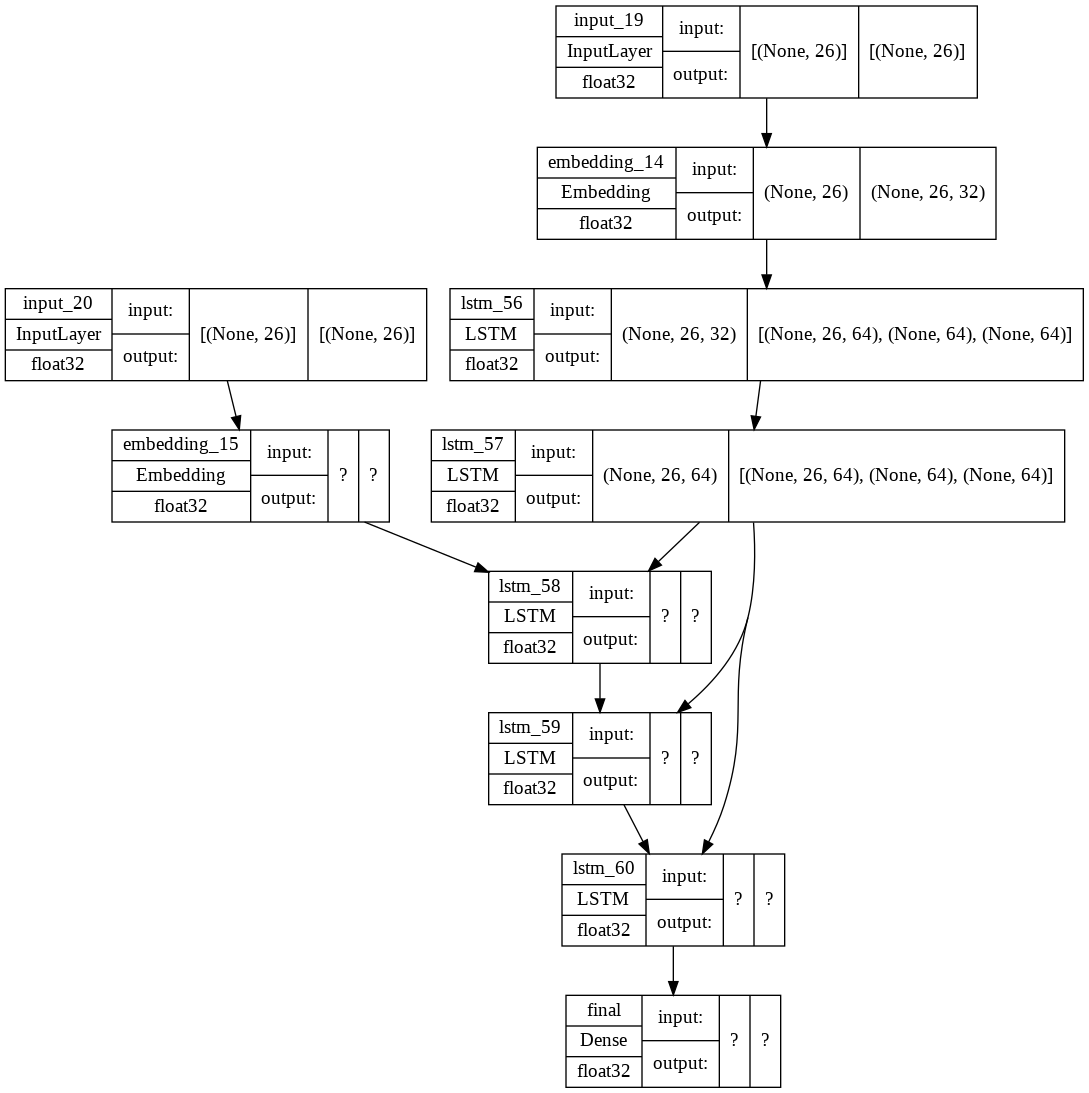

In [75]:
plot_model(model, to_file='model.png', show_shapes=True, show_dtype=True,show_layer_names=True, dpi=96 )

In [59]:
encoder_inference_model,decoder_inference_model = build_inference_model(model,2,3,64)

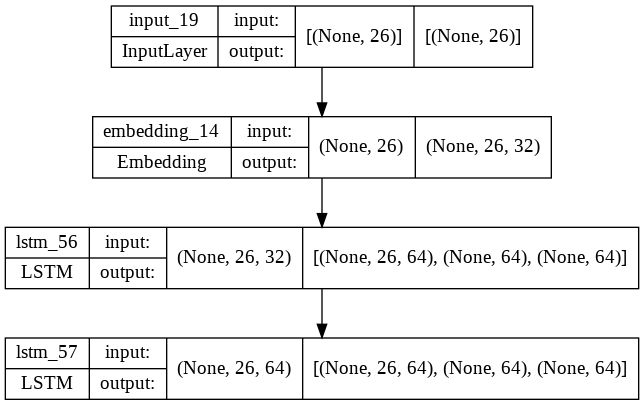

In [60]:
plot_model(encoder_inference_model, to_file='model.png', show_shapes=True)

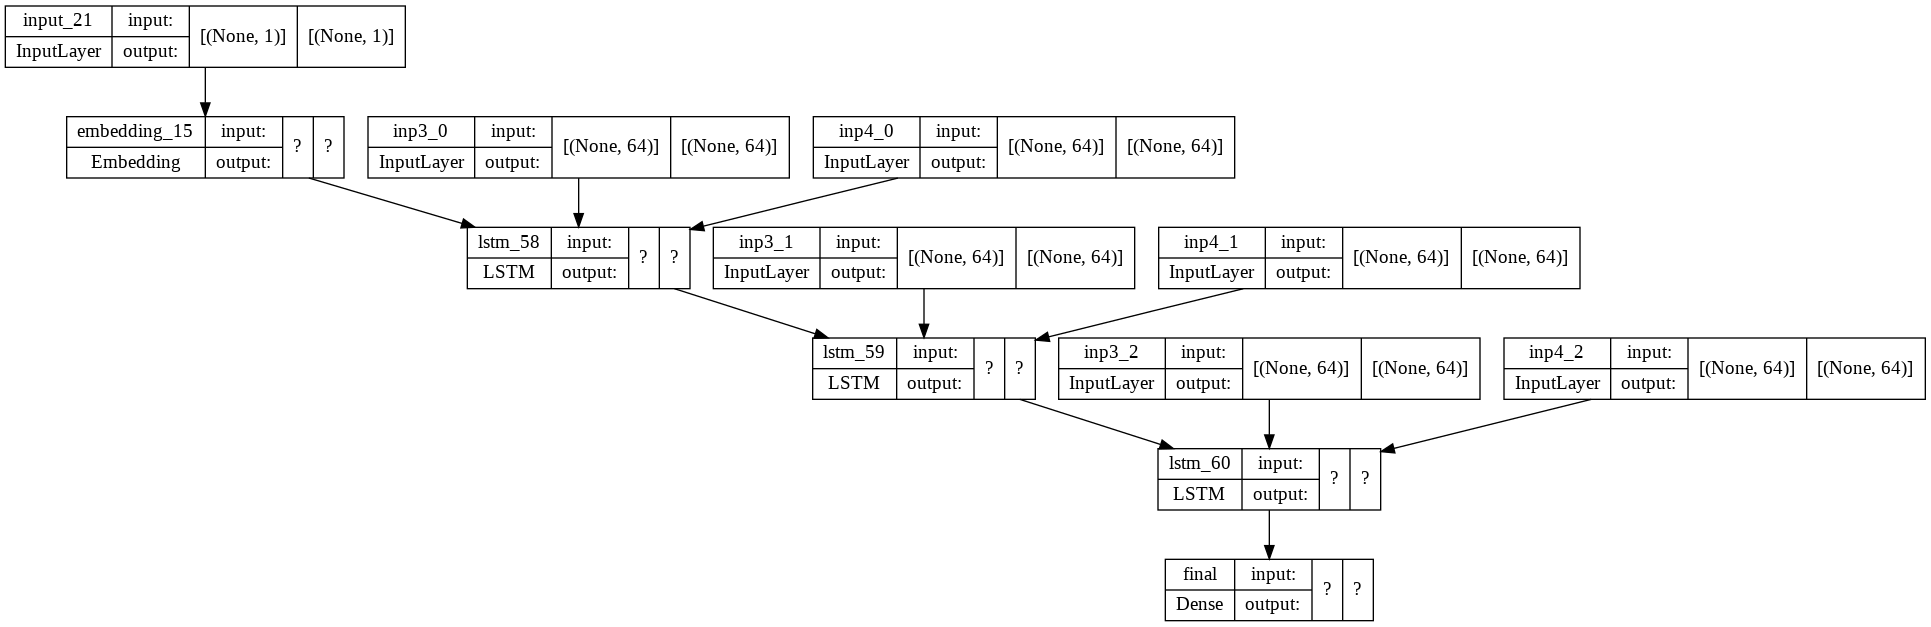

In [61]:
plot_model(decoder_inference_model, to_file='model.png', show_shapes=True)

In [40]:
index_to_char_target = dict((target_tokenizer.word_index[key], key) for key in target_tokenizer.word_index.keys())

In [74]:
def decode_batch_of_sequences(rnn_type,input_seq,encoder_model,decoder_model,batch_size,encoder_layers,decoder_layers):
    # Get encoder output
    encoder_output_state_values = encoder_model.predict(input_seq)
    if rnn_type=='GRU' or 'RNN':
      decoder_input_state_values=[encoder_output_state_values]
    
    # This is needed because encoder state is fed to all decoder layers
    decoder_input_state_values = decoder_input_state_values * decoder_layers
    
    # This is contain previously predicted character's index for every words in batch.
    prev_char_index = np.zeros((batch_size, 1))
    # We start with \t for every word in batch
    prev_char_index[:, 0] = target_tokenizer.word_index['\t']
    
    predicted_words = [ "" for i in range(batch_size)]
    done=[False for i in range(batch_size)]
    for i in range(max_decoder_seq_length):
        decoder_out = decoder_model.predict(tuple([prev_char_index] + decoder_input_state_values))
        # Decoder output has both output of all timesteps followed by hidden states
        output_probability = decoder_out[0]
        # Decoder state input is previous layer state output
        decoder_input_state_values = decoder_out[1:]
        for j in range(batch_size):
          if done[j]:
            continue          
          sampled_token_index = np.argmax(output_probability[j, -1, :])
          if sampled_token_index == 0:
            sampled_char='\n'
          else:
            sampled_char = index_to_char_target[sampled_token_index]
          if sampled_char == '\n':
            done[j]=True
            continue            
          predicted_words[j] += sampled_char
          #update the previously predicted characters        
          prev_char_index[j,0]=target_tokenizer.word_index[sampled_char]
    return predicted_words

In [26]:
ee = [1,2,3]
print(ee)
fee = [ee] +[[4,5,6]]
print(fee)
foo = np.zeros(shape=(3,1))
foo[:,0]=1
print(str(foo))

[1, 2, 3]
[[1, 2, 3], [4, 5, 6]]
[[1.]
 [1.]
 [1.]]


In [65]:
model.inputs[0]

<KerasTensor: shape=(None, 26) dtype=float32 (created by layer 'input_21')>

In [35]:
model.layers
